# Positive Only Sparse Coding on MNIST

This code implements Positive Only Sparse Coding on MNIST.

Lets break that down.

Sparse Coding is an algorithm that seeks to disentangle the underlying generative factors of data. In this particular case, we are considering the dataset, MNIST, which is a collection of digits. Intuitively speaking, the underlying generative factors of digits are pen strokes. When these strokes are combined in the right way, we get digits. We will see that sparse coding discovers this underlying structure. 

In sparse coding, we define the following:
$I$ is an image, $D$ is a dictionary of underlying generative factors, and $A$ the sparse coefficients. In long form, 

$$I(x) = d_1(x) * a_1 + d_2(x) * a_2 + \ldots$$

where the dictionary elements are the same for any image in the data set, and the coefficients, $a$, are different for each image. 

In order to learn the dictionary elements $D$, and the sparse coefficients, $A$, we minimize the following objective function:

$$E = |I - A * D| ^ 2 + |A|_1 \qquad \sum_x d_i(x)^2 = 1$$

(Note $D$ is number of dictionary elements by the number of pixels). To minimize this function, we do the following steps:

0. Choose an initial value of $D$.

1. Choose a batch of images $I$.

2. Minimize $E$ with respect to $A$ - we use FISTA which is a slighly better version of gradient descent.

3. Keeping that value of $A$, reduce $E$ by one gradient step in the direction of $\nabla_D E$. 

4. Return to step 1. 

In [1]:
import os
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import savemat, loadmat
from scipy.linalg import eigh
from scipy.stats import probplot, expon
import theano
import theano.tensor as T

from utils.rf_plot import show_fields
from utils.fista import fista_updates, ista_updates

Using gpu device 0: Tesla K40c (CNMeM is disabled)


In [235]:
# Load in the data
data_dir = "data/final/"
data_fil = "mnist.mat"
output_dir = 'output/'

data = loadmat(data_dir + data_fil)
IMAGES = data['IMAGES']
LABELS = data['LABELS']

pos_only = True # Positive Only Sparse coding if True
    
# Scale Images to have equal standard deviations and pixels between 0 and 1
K = IMAGES.shape[0]
IMAGES = IMAGES / np.std(IMAGES.astype('float32'), axis = (1, 2), keepdims = True)
IMAGES = IMAGES / np.max(IMAGES).astype('float32')

# Set basic parameters
(K, L_img, L_img) = IMAGES.shape  
K # Number of base images
L_img # Linear size of images from the data
N_pix_img = L_img ** 2

L_pat = L_img  # Size of image patch
N_pix = L_pat ** 2  # Number of pixels in a patch
N_sp = 81 # Number of sparse dictionary elements
N_bat = 200 # Number of images in a batch
Alpha = 0.015 # coefficient for the sparse coefficients
Eta = 0.01 # Dictionary Learning Step Size (annealed, see later)

D_std = np.std(IMAGES) # Standard deviation for dictionary elements
D = np.zeros((N_sp, N_pix), dtype = 'float32') # Dictionary
D[:, :] = np.random.uniform(size=D.shape) # Randomly initialize the dictionary
D = D_std * D / np.sqrt(np.sum(D ** 2, axis=1, keepdims=True)) # Normalize dictionary elements
A = np.zeros((N_bat, N_sp), dtype = 'float32') # Initialize sparse coefficients
# I_bat = np.zeros((N_bat, N_pix), dtype = 'float32') # Image batch
# I - A * D

Effective Dimensionality of the data

In [ ]:
IM1 = IMAGES.reshape(K, N_pix_img)
from scipy.linalg import eigh
IM_cov = np.cov(IM1.T)
evals, evecs = eigh(IM_cov)
plt.plot(np.log(evals[::-1])[0:-8])

In [ ]:
plt.title('Percent variance explained as a number of eigenvectors')
cs = np.cumsum(evals[::-1])
plt.plot(cs / cs[-1])

In order to calculate the derivatives necessary to do the minimization, we use a popular python package that is popular in the machine learning called theano. The idea is that we build up our objective function in terms of symbolic variables, and then we can use theano to automatically calculate the derivatives for us. Also theano allows for us to run the code on either a CPU or a GPU without changing our code. 

In [236]:
def threshold(t_X, pos_only=True):
    """
    Threshold function. Does nothing if not positive only
    """
    if pos_only:
        return T.switch(t_X > 0., t_X, -0.00 * t_X )
    else:
        return t_X

t_Alpha = T.scalar('Alpha')
t_L = T.scalar('L')
t_Eta = T.scalar('eta')
t_D_std = T.scalar('D_std')

t_I = theano.shared(IMAGES.reshape(K, N_pix_img).astype('float32'), 'I')
t_D = theano.shared(D, 'D')
t_A = theano.shared(A, 'A')
t_I_idx = T.ivector('I_idx') # Indicies into t_I to select a batch of images

t_E_rec = T.sum((t_I[t_I_idx] - T.dot(t_A, t_D)) ** 2); t_E_rec.name = 'E_rec'
t_E_sp = t_Alpha * T.sum(T.abs_(t_A)); t_E_sp.name = 'E_sp'
t_E = t_E_rec + t_E_sp; t_E.name = 'E'

t_Signal = T.sum(t_I[t_I_idx] ** 2)
t_SNR = t_Signal / t_E_rec # FIXME: Not quite right

t_SNR = T.mean(
    T.sum(t_I[t_I_idx] ** 2, axis = 1) / 
    (0.000001 + T.sum((t_I[t_I_idx] - T.dot(t_A, t_D)) ** 2, axis = 1)))

t_gED = T.grad(t_E_rec, t_D)

costs = theano.function(inputs = [t_I_idx, t_Alpha],
                        outputs = [t_E, t_E_rec, t_E_sp, t_SNR])

def row_norm(t_X, t_std = t_D_std):
    """
    Returns row normalized version of a theano matrix t_X
    the rows have a norm of t_std
    """
    return t_std * t_X / T.sqrt(0.000001 + T.sum(t_X ** 2, axis = 1)).dimshuffle(0, 'x')

dictionary_learning_step = theano.function(
    inputs = [t_Alpha, t_Eta, t_D_std, t_I_idx],
    outputs = [t_E, t_E_rec, t_E_sp],
    updates = [(t_D, row_norm(threshold(t_D - t_Eta * row_norm(t_gED))))])

In [237]:
fist_updates = fista_updates(t_A, t_E_rec, t_Alpha, t_L, pos_only=pos_only)
_, t_fista_X, t_T = fist_updates.keys()

fista_step = theano.function(inputs = [t_Alpha, t_L, t_I_idx],
                             outputs = [t_E, t_E_rec, t_E_sp, t_SNR],
                             updates = fist_updates)
def calculate_fista_L():
    """
    Calculates the 'L' constant for FISTA for the dictionary in t_D.get_value()
    """
    D = t_D.get_value()
    try:
        L = (2 * eigh(np.dot(D, D.T), eigvals_only=True, eigvals=(N_sp-1,N_sp-1))[0]).astype('float32')
    except ValueError:
        L = (2 * D_std ** 2 * N_sp).astype('float32') # Upper bound on largest eigenvalue
    return L

def reset_fista_variables():
    """
    Resets fista variables
    """
    A0 = np.zeros_like(t_A.get_value()).astype(theano.config.floatX)
    t_A.set_value(A0)
    t_fista_X.set_value(A0)
    t_T.set_value(np.array([1.]).astype(theano.config.floatX))

In [238]:
def train(N_itr, Alpha, Eta, cost_list, N_g_itr = 200, show_costs = True):
    """
    Code to train a sparse coding dictionary
    N_itr - Number of iterations, a new batch of images for each
    Alpha - Sparsity cost parameter... E = E_rec + Alpha + |A|_1
    cost_list - list to which the cost at each iteration will be appended
    N_g_itr - number of gradient steps in FISTA
    show_costs - If true, print out costs every N_itr/10 iterations
    Returns I_idx - indices corresponding to the most recent image batch,
        to be used later in visualizations
    """
    if show_costs:
        print 'Iteration, E, E_rec, E_sp, SNR'
    for i in range(N_itr):
        I_idx = np.random.randint(K, size = N_bat).astype('int32')
        reset_fista_variables()
        L = calculate_fista_L()
        for _ in range(N_g_itr):
            E, E_rec, E_sp, SNR = fista_step(Alpha, L, I_idx)
        dictionary_learning_step(Alpha, Eta, D_std, I_idx)
        # 
        E, E_rec, E_sp, SNR = costs(I_idx, Alpha)
        cost_list.append(E)
        if ((i + 1) % (1 + N_itr / 10) == 0) and show_costs:
            print i, E, E_rec, E_sp, SNR
    return I_idx

In [239]:
cost_list = []
show_costs=True

In [240]:
I_idx = train(500, Alpha, 0.05, cost_list, show_costs=show_costs)

Iteration, E, E_rec, E_sp, SNR
50 187.111206055 130.421234131 56.6899642944 9.66271018982
101 173.115859985 106.342681885 66.7731781006 11.6533679962
152 161.856201172 88.1924591064 73.6637420654 13.6920003891
203 155.922515869 76.7095031738 79.2130050659 15.4115381241
254 155.924163818 74.2292480469 81.6949157715 16.4593811035
305 151.422119141 69.728263855 81.6938476562 17.4037837982
356 154.222167969 69.1270675659 85.0951004028 17.6356754303
407 151.787353516 68.0955200195 83.6918258667 18.1999416351
458 151.763366699 68.2871551514 83.4762115479 18.2844276428


In [241]:
I_idx = train(500, Alpha, 0.02, cost_list, show_costs=show_costs, N_g_itr = 300)

Iteration, E, E_rec, E_sp, SNR
50 155.195602417 68.2000274658 86.9955749512 18.029378891
101 153.165145874 66.9022598267 86.2628860474 18.4941501617
152 154.420547485 67.6534729004 86.767074585 19.2064590454
203 144.642211914 59.1986618042 85.4435577393 20.8069820404
254 157.242370605 72.1404571533 85.1019058228 16.877954483
305 148.744110107 62.5542907715 86.1898117065 19.5008773804
356 153.611160278 67.9651489258 85.6460113525 18.2950611115
407 155.678039551 68.3041687012 87.373878479 18.6247634888
458 152.138244629 65.7629318237 86.3753204346 18.3370475769


In [259]:
D1 = t_D.get_value().copy()

In [260]:
I_idx = train(100, Alpha, 0.01, cost_list, show_costs=show_costs, N_g_itr = 300)

Iteration, E, E_rec, E_sp, SNR
10 153.131317139 65.9440917969 87.1872329712 19.5122070312
21 154.463088989 67.7760162354 86.6870727539 18.0711212158
32 150.17149353 63.8435211182 86.3279724121 21.0033340454
43 150.1171875 62.5055389404 87.611656189 18.9855823517
54 155.39402771 68.4530334473 86.9409942627 18.2763061523
65 156.752532959 70.8193130493 85.9332122803 18.1466274261
76 151.426086426 65.036277771 86.3898010254 18.7488746643
87 152.97479248 66.5826034546 86.3921966553 19.1882553101
98 158.191741943 70.8724975586 87.3192443848 18.8870201111


In [261]:
I_idx = train(1, Alpha, 0.001, [], show_costs=show_costs, N_g_itr=300)

Iteration, E, E_rec, E_sp, SNR
0 151.198394775 65.2248306274 85.9735565186 19.3871917725


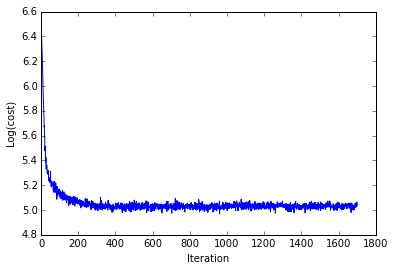

In [262]:
plt.plot(np.log(np.array(cost_list)))
plt.xlabel('Iteration')
plt.ylabel('Log(cost)')

To Demonstrate Convergence, we run the minimization for a number of steps and note that the dictionary doesn't fluctuate systematically. 

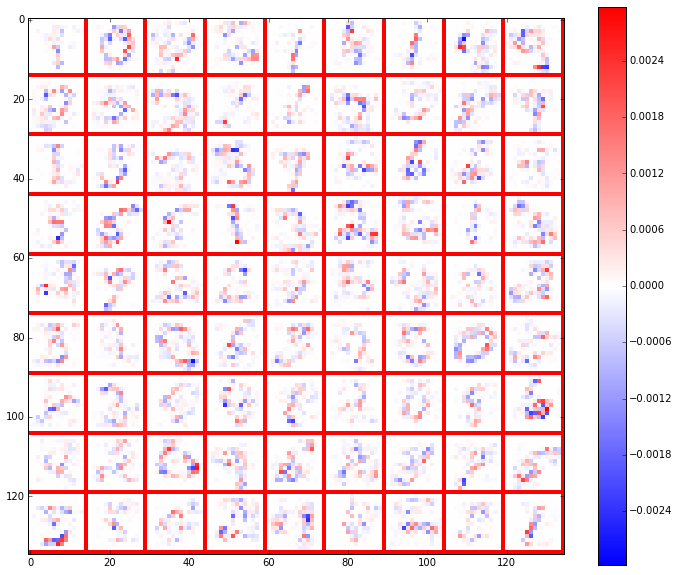

In [263]:
plt.figure(figsize=(12,10))
show_fields(t_D.get_value() - D1)

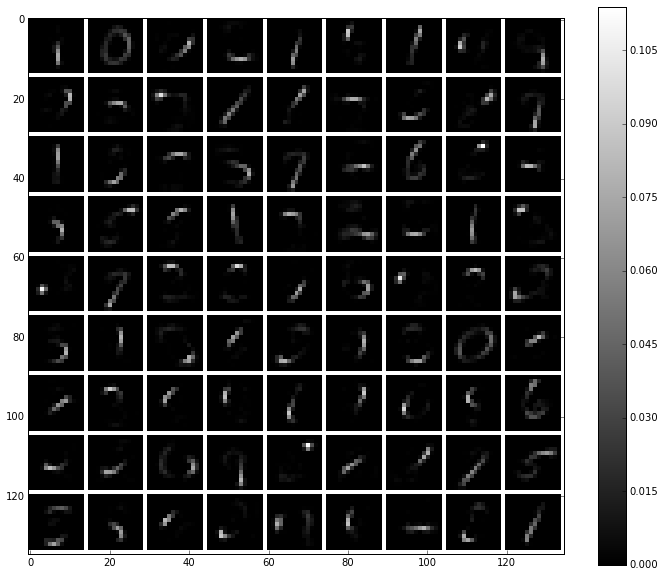

In [277]:
plt.figure(figsize=(12,10))
show_fields(t_D.get_value(), cmap = plt.cm.gray, pos_only = True)
plt.savefig(os.path.join(output_dir, 'mnist_basis.png'), dpi = 200)

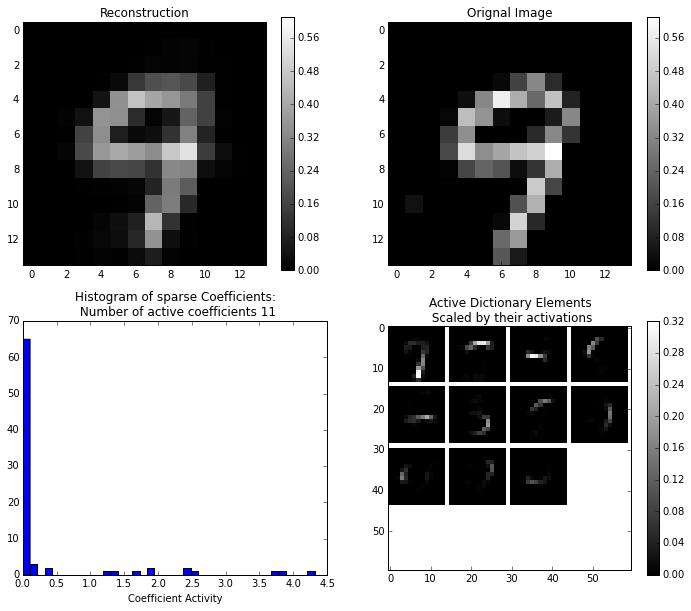

In [276]:
plt.figure(figsize=(12, 10))
# q = np.random.randint(N_bat)
plt.subplot(2, 2, 1)
plt.title('Reconstruction')
plt.imshow(np.dot(t_A.get_value(), t_D.get_value())[q].reshape(L_pat, L_pat),
           interpolation = 'nearest',
           cmap = plt.cm.gray, vmin = 0, vmax = t_I.get_value()[I_idx][q].reshape(L_pat, L_pat).max())
plt.colorbar()
plt.subplot(2, 2, 2)
plt.title('Orignal Image')
plt.imshow(t_I.get_value()[I_idx][q].reshape(L_pat, L_pat),
           interpolation = 'nearest',
           cmap = plt.cm.gray)
plt.colorbar()
plt.subplot(2, 2, 3)

plt.hist(t_A.get_value()[q], bins=40)

sort_idx = np.argsort(t_A.get_value()[q])[::-1]
N_active = np.sum(t_A.get_value()[q] > 0.5)
active_idx = sort_idx[0:N_active]

plt.title('Histogram of sparse Coefficients: \n Number of active coefficients %d' % N_active)
plt.xlabel('Coefficient Activity')

plt.subplot(2, 2, 4)
show_fields(t_D.get_value()[active_idx] * 
            t_A.get_value()[q][active_idx][:, np.newaxis], 
            cmap = plt.cm.gray, pos_only = True)
plt.title('Active Dictionary Elements \n Scaled by their activations')
plt.savefig(os.path.join(output_dir, 'example_reconstruction.png'), dpi = 200)

((array([  1.96081239e-04,   4.76018879e-04,   7.59049831e-04, ...,
           7.18382263e+00,   7.65029104e+00,   8.53707954e+00]),
  array([  6.29282431e-06,   3.15038305e-05,   4.16144903e-04, ...,
           9.88679123e+00,   1.02313261e+01,   1.07980766e+01], dtype=float32)),
 (1.4369119535418897, 0.017792957896009209, 0.99918442151762321))

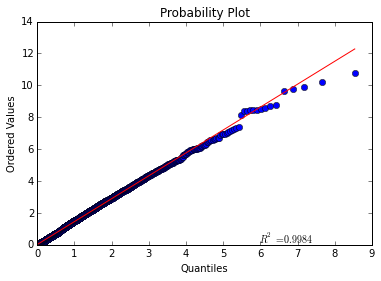

In [67]:
As = t_A.get_value().ravel()
probplot(As[As > 0], dist = expon, plot = plt)

# Comparison of FISTA, ISTA, and ADADelta

In order to check our implementation of FISTA, we compare it to the convergence of ISTA. 

In [73]:
ist_updates = ista_updates(t_A, t_E_rec, t_Alpha, t_L, pos_only=pos_only)

ista_step = theano.function(inputs = [t_Alpha, t_L, t_I_idx],
                             outputs = [t_E, t_E_rec, t_E_sp, t_SNR],
                             updates = ist_updates)
def reset_ista_variables():
    """
    Resets fista variables
    """
    A0 = np.zeros_like(t_A.get_value()).astype(theano.config.floatX)
    t_A.set_value(A0)

In [74]:
from utils.theano_gradient_routines import ada_delta
t_Rho = T.scalar('Rho')
t_Eps = T.scalar('Eps')
ada_updates = ada_delta(t_E, t_A, *(t_Rho, t_Eps))
t_ada_Eg2, t_ada_dA2, _ = ada_updates.keys()

ada_delta_step = theano.function(inputs = [t_Alpha, t_I_idx, t_Rho, t_Eps],
                                 outputs = [t_E, t_E_rec, t_E_sp, t_SNR],
                                 updates = ada_updates)

def reset_adadelta_variables():
    """
    Resets ADA Delta auxillary variables
    """
    A0 = np.zeros_like(t_A.get_value()).astype(theano.config.floatX)
    t_ada_Eg2.set_value(A0)
    t_ada_dA2.set_value(A0)
    t_A.set_value(A0)

In [75]:
N_bat = 200
t_A.set_value(np.zeros((N_bat, N_sp)).astype(theano.config.floatX))

In [76]:
L = (calculate_fista_L()).astype('float32')
I_idx = np.random.randint(K, size = N_bat).astype('int32')
N_g_itr = 1000

In [77]:
ada_cost_list = []
reset_adadelta_variables()
Eps = 0.1
Rho = 0.8
for _ in range(N_g_itr):
    E, E_rec, E_sp, SNR = ada_delta_step(Alpha, I_idx, Rho, Eps)
    ada_cost_list.append(E)
ada_cost_array = np.array(ada_cost_list) / N_bat

((array([  7.68626281e-05,   1.86581156e-04,   2.97492842e-04, ...,
           8.12026914e+00,   8.58673755e+00,   9.47352921e+00]),
  array([  5.54230064e-06,   6.16908073e-06,   8.51880759e-06, ...,
           1.06351614e+01,   1.13023033e+01,   1.25872087e+01], dtype=float32)),
 (1.1412829976527024, -0.49682978289385615, 0.96923357931997856))

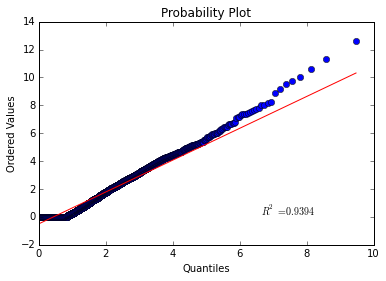

In [78]:
As = t_A.get_value().ravel()
probplot(As[As > 0], dist = expon, plot = plt)

In [79]:
fista_cost_list = []
reset_fista_variables()
for _ in range(N_g_itr):
    E, E_rec, E_sp, SNR = fista_step(Alpha, L, I_idx)
    fista_cost_list.append(E)
fista_cost_array = np.array(fista_cost_list) / N_bat

In [80]:
ista_cost_list = []
reset_ista_variables()
for _ in range(N_g_itr):
    E, E_rec, E_sp, SNR = ista_step(Alpha, L, I_idx)
    ista_cost_list.append(E)
ista_cost_array = np.array(ista_cost_list) / N_bat

In [81]:
m = np.min([np.min(fista_cost_array), 
            np.min(ista_cost_array),
           np.min(ada_cost_array)])
c0 = fista_cost_array[0]
x_itr = 1 + np.arange(N_g_itr)

The following plot shows the convergence for ISTA and FISTA. Suppose we are trying to minimize $F(x)$ and $x^*$ is $\text{argmin}_x F(x)$. If $k$ is the iteration number, then the theoretical bounds say that the error for ISTA scales as $O(1/k)$ and the error for FISTA scales as $O(1/k^2)$. The dotted lines show these two scalings. We can see roughly that the FISTA error scales as we want, as does the ISTA error. However, after about $100$ iterations, both functions start scaling down faster. This might be due to the lack of complexity of this minimization problem or the fact that we are doing float32 computations.

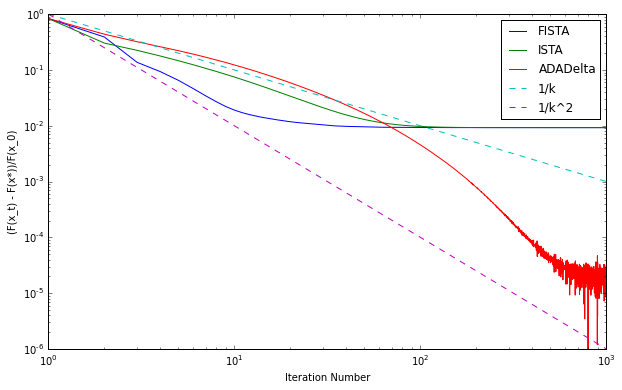

In [82]:
plt.figure(figsize=(10,6))
plt.plot(x_itr, (fista_cost_array - m)/c0, label = 'FISTA')
plt.plot(x_itr, (ista_cost_array - m)/c0, label = 'ISTA')
plt.plot(x_itr, (ada_cost_array - m) /c0, label = 'ADADelta')
plt.plot(x_itr, 1./x_itr, label='1/k', ls='--')
plt.plot(x_itr, 1./x_itr**2, label='1/k^2', ls='--')
plt.legend(loc = 0)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iteration Number')
plt.ylabel('(F(x_t) - F(x*))/F(x_0)')

Details on FISTA:

Since the objective function has an absolute value, typical gradient descent approaches converge slowly. Thus there are special purpose gradient descent methods that minimize functions that are in the form $$f(x) + g(x)$$ where $f(x)$ is a continuously differentiable, convex function and $g(x)$ is a convex, but not continuously differentiable function, such as $g(x) = \alpha |x|$. One such method is called FISTA, or the Fast Iterative Shrinkage-Threshold Algorithm. 

The core kernel of the FISTA algorithm is the ISTA step:

Define
$$p_L(y) = \text{argmin}_x \, g(x) + L/2 * ||x- g(y)||^2$$ where $$g(y) = y - \frac{1}{L} \nabla f(y)$$

and where $L$ is the constant such that $$||\nabla f(x) - \nabla f(y)|| \le L ||x - y||$$

When $g(x) = \alpha|x|_1$, then $$p_L(y) = h_\theta(g(y))\qquad h_\theta(y) = \text{sign}(y)(|y|-\theta)\qquad \theta = \frac{\alpha}{L}$$
$h$ is applied pointwise to $y$ and is the shrinkage function. Simplying calculating $x_{t+1} = p_L(x_t)$ is the ISTA algorithm. If we more intelligently choose our new value to probe our function, then we get faster convergence. The FISTA algorithm is as follows:

1. Initialize $y_0 = x_0 = X0$, $t_0=1$. 

2. For $k \ge 0$, iterate the following:

$$x_{k+1} = p_L(y_k)\qquad t_{k+1} = 0.5 * (1 + \sqrt{1 + 4 * t_k ^2})\qquad y_{k+1} = x_{k+1} + \frac{t_k - 1}{t_{k+1}} * (x_{k+1} - x_k)$$

In [278]:
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [279]:
savemat(os.path.join(output_dir, 'mnist_dictionary.mat'), 
       {'D': t_D.get_value(), 'Alpha': Alpha,
        'Algorithm': 'Positive Only FISTA',
        'Normalization': 'Equal Standard Deviation'})